### Problem definition

Используя исторические данные в таблице построить модель для выявления фродовых транзакций

### Import primary dependencies

In [393]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 50
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [394]:
# set constants
PATH = '../files/df.csv'
SEED = 11

In [395]:
df = pd.read_csv(PATH)

# Data exploration

In [396]:
df.head()

,is_fraud,transaction_amount,relative_timestamp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,0,118.44,159609.0,1.928977,-0.745709,-1.742981,-0.247731,-0.379232,-1.504379,0.426988,-0.560930,-1.346733,1.047987,1.336412,1.404223,1.062332,0.470407,-1.328266,-2.153751,0.080569,0.738571,-0.566688,-0.348429,-0.096171,0.153526,-0.001283,0.631590,0.130582,0.758711,-0.113741,-0.063939,0.795595,-2.200074
1,0,1.98,162525.0,2.060450,-0.136926,-1.085910,0.430300,-0.254977,-1.247417,0.104193,-0.267854,0.721569,0.108246,-0.936630,-0.193028,-1.130690,0.513458,0.170295,-0.051804,-0.216638,-0.726115,0.150763,-0.300772,-0.302288,-0.795267,0.355477,0.013651,-0.340015,0.199361,-0.078557,-0.062377,0.921937,0.216959
2,0,103.00,58956.0,1.114014,-1.533296,0.741385,-1.385897,-1.241643,1.088519,-1.433041,0.390210,-1.711226,1.180505,0.808971,-0.194381,0.899373,-0.422711,1.870341,-1.518903,1.674176,-1.777327,-2.147259,-0.254369,0.140363,0.783574,0.082555,-0.615175,-0.036441,-0.006456,0.109368,0.032635,0.225000,-2.467540
3,0,16.70,148842.0,0.514410,1.389934,-1.091181,1.604760,0.460984,-0.381953,-0.599145,-2.721896,-0.567445,-1.458127,0.125269,-0.445574,-1.347590,-1.198823,1.026539,0.531775,1.904563,0.543099,-0.324569,0.595534,-1.670931,-0.854670,0.130428,0.789378,0.909599,-0.692159,-0.033316,0.096833,0.586722,1.187643
4,0,110.14,125542.0,-0.849330,0.399191,-0.319642,-1.220384,1.062371,1.752440,0.558836,0.895163,-0.241615,-1.275903,0.391643,1.113145,0.105190,0.527055,-0.633773,-0.869942,0.258944,-1.019820,-0.281717,-0.048197,0.134113,0.278606,0.198983,-0.936208,-0.477630,-0.087217,0.035566,0.090183,0.569712,-1.485808


Посмотрим на типы данных каждой колонки

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 33 columns):
is_fraud              284807 non-null int64
transaction_amount    284807 non-null float64
relative_timestamp    284807 non-null float64
F1                    284807 non-null float64
F2                    284807 non-null float64
F3                    284807 non-null float64
F4                    284807 non-null float64
F5                    284807 non-null float64
F6                    284807 non-null float64
F7                    284807 non-null float64
F8                    284807 non-null float64
F9                    284807 non-null float64
F10                   284807 non-null float64
F11                   284807 non-null float64
F12                   284807 non-null float64
F13                   284807 non-null float64
F14                   284807 non-null float64
F15                   284807 non-null float64
F16                   284807 non-null float64
F17              

Итого:
    
    - бинарная целевая переменная (очень несбалансированая)
    - 28 количественных фичей - transaction_amount - ненормализированая
    - 1 фича - временная, выражена в секундах

In [398]:
df_cp = df.copy()

In [399]:
# get relative-timestamp 
df_cp['relative_timestamp'] = pd.to_timedelta(df_cp['relative_timestamp'].astype(np.int32), unit='s')

In [400]:
# check relative timestamp in days summary statistics
df_cp['relative_timestamp_days'] = df_cp['relative_timestamp'].dt.days
df_cp['relative_timestamp_hours'] = df_cp['relative_timestamp'].dt.seconds // 60 // 60

Проверим данные на наличие пропущенных значений

In [401]:
df_cp.isnull().sum()

is_fraud                        0
transaction_amount              0
relative_timestamp              0
F1                              0
F2                              0
F3                              0
F4                              0
F5                              0
F6                              0
F7                              0
F8                              0
F9                              0
F10                             0
F11                             0
F12                             0
F13                             0
F14                             0
F15                             0
F16                             0
F17                             0
F18                             0
F19                             0
F20                             0
F21                             0
F22                             0
F23                             0
F24                             0
F25                             0
F26                             0
F27           

В двух фичах есть пропущенные значения, я заполню их значениям медианы конкретного атрибута/фичи

In [402]:
median_values = df_cp.median()
df_cp.fillna(median_values, inplace=True)

Посмотрим на распределение целевой переменной

In [403]:
df_cp['is_fraud'].value_counts()

0    284315
1       492
Name: is_fraud, dtype: int64

so much imbalance..

При построении модели возможно стоит попробовать применить методы over/under/synthetic семплинга, что бы увеличить кол-во объектов в класе, который в меньшенстве.

Далее рассмотрим статиситки для каждой фичи

In [404]:
np.round(df_cp.describe())

,is_fraud,transaction_amount,relative_timestamp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,relative_timestamp_days,relative_timestamp_hours
count,284807.0,284807.0,284807,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
mean,0.0,88.0,1 days 02:20:13.859575,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,14.0
std,0.0,250.0,0 days 13:11:28.145954,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,6.0
min,0.0,0.0,0 days 00:00:00,-56.0,-73.0,-48.0,-6.0,-114.0,-26.0,-44.0,-73.0,-13.0,-25.0,-5.0,-19.0,-6.0,-19.0,-4.0,-14.0,-25.0,-9.0,-7.0,-54.0,-35.0,-11.0,-45.0,-3.0,-10.0,-3.0,-23.0,-15.0,-1.0,-3.0,0.0,0.0
25%,0.0,6.0,0 days 15:03:21.500000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,0.0,10.0
50%,0.0,22.0,0 days 23:31:32,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,15.0
75%,0.0,77.0,1 days 14:42:00.500000,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.0
max,1.0,25691.0,1 days 23:59:52,2.0,22.0,9.0,17.0,35.0,73.0,121.0,20.0,16.0,24.0,12.0,8.0,7.0,11.0,9.0,17.0,9.0,5.0,6.0,39.0,27.0,11.0,23.0,5.0,8.0,4.0,32.0,34.0,1.0,3.0,1.0,23.0


Рассмотрим медианы фичей в разрезе целевой переменной

In [405]:
df_cp.groupby('is_fraud').median()

,transaction_amount,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,relative_timestamp_days,relative_timestamp_hours
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,22.00,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,-0.091872,-0.034923,0.141679,-0.013547,0.051947,0.048294,0.067377,-0.064833,-0.002787,0.003117,-0.062646,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,0.000744,0.005981,0,15
1,9.25,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.729720,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,0.031120,0.217147,0,12


Видно, что те транзакции, которые помечены как фродовые - имеют крайне высокие или крайне низкие значения, исходя из медиан фичей.
Также, можно наблюдать что фродовые транзакции имеют относительно невысокий transaction_amount.
После экстракта дней и часов из relative_timestamp - фича как разница в днях (relative_timestamp_days) - не показывает каких либо значимых различий, а вот разница в часах - мы можем наблюдать разницу в два часа по медианам, возможно это поможет в будущем.

Далее, посмотрим на кореляцию количественных признаков.

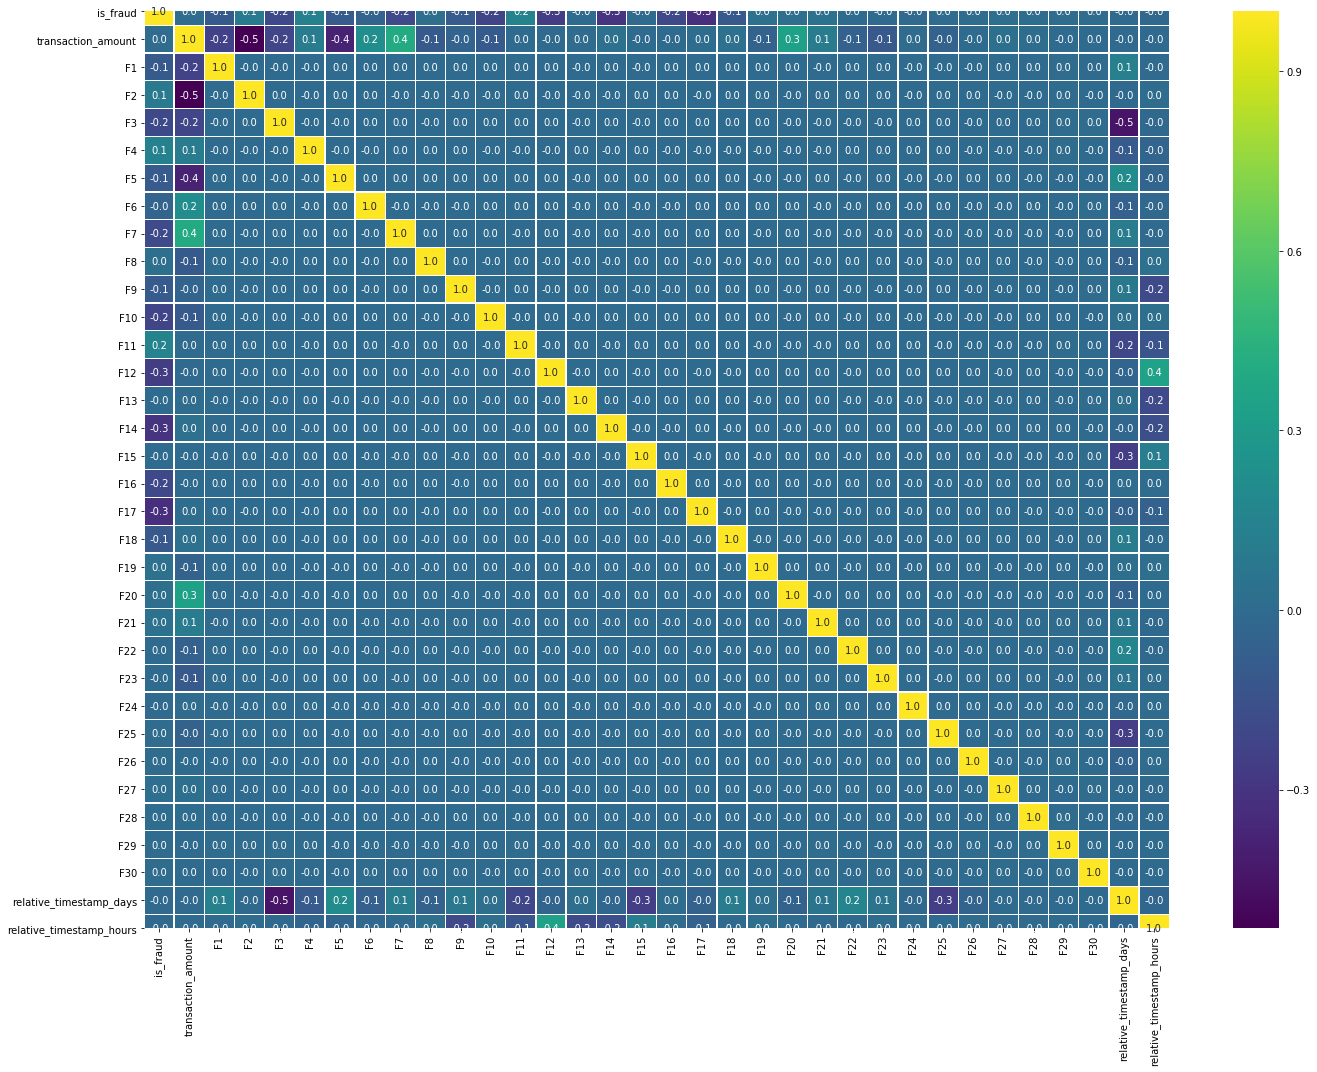

In [406]:
corr_df = df_cp.corr()
f,ax = plt.subplots(1,1,figsize=(20,15))
sns.heatmap(corr_df, cmap='viridis',annot=True, fmt=".1f", linewidths=.3)
plt.tight_layout()

На хитмапе кореляций признаков нет сильно корелирущих фичей. Также можно заметить что есть некий пул фичей с относительно сильной кореляцией на целевую переменную.

Далее, посмотрим на распределение каждой фичи отдельно.

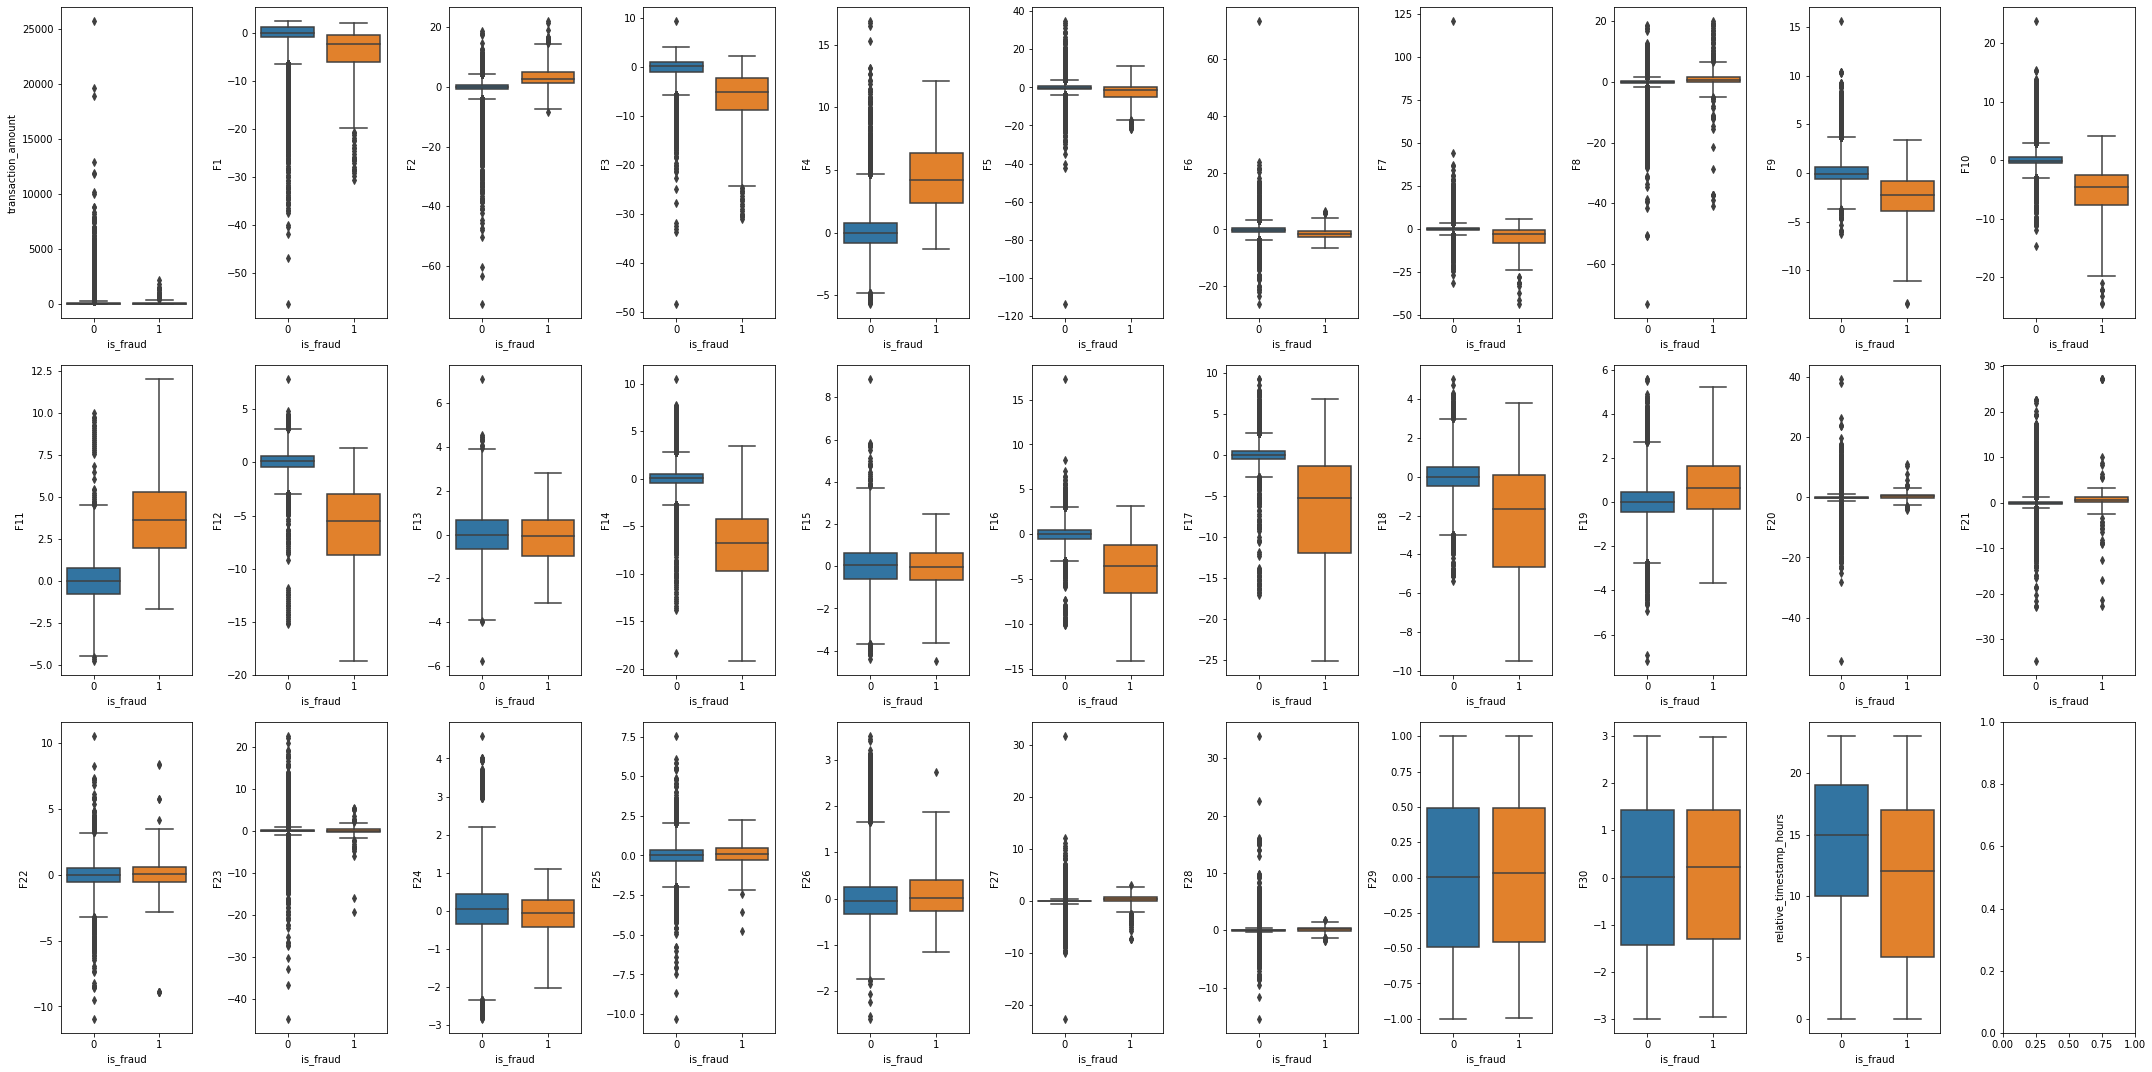

In [407]:
features = df_cp.drop(['is_fraud','relative_timestamp','relative_timestamp_days'],1).columns

fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(30, 15))
axes = axes.ravel()
for idx, feat in  enumerate(features):
    sns.boxplot(x='is_fraud', y=feat, data=df_cp, ax=axes[idx], whis = 2.5)
    axes[idx].set_xlabel('is_fraud')
    axes[idx].set_ylabel(feat)
    
plt.tight_layout()

На глаз наибольшее отличие мы видим для признаков F1, F2, F3, F4, F9, F10, F11, F12, F14 ,F16, F17, F18, realative_timestamp_hours. 

Также, некоторые из фичей имеет много выбросов, а именно transaction_amount, F1,F2,F5,F6,F7,F8,F10,F17,F20,F21,F23,F27,F28 - для этих фичей можно отобрать те объэкты, которые находятся за рамками 99 персентиля фичи и использовать это как фичу - содержит ли обьект аномально высокие значения в какой то из фичeй или нет.
    

In [408]:
features_with_anomalies = ['transaction_amount','F1','F2','F3','F5','F6','F7','F8','F10','F17','F20','F21','F23','F27','F28']

In [409]:
extreme_high = df_cp[features_with_anomalies].quantile(.99)
extreme_low = df_cp[features_with_anomalies].quantile(.01)

In [410]:
cnt_anomaly_values = pd.DataFrame(np.where((df_cp[features_with_anomalies] < extreme_high) &
             (df_cp[features_with_anomalies] > extreme_low),
             df_cp[features_with_anomalies], np.nan)).isnull().sum(1)

In [411]:
df_cp['is_anomaly_value'] = (cnt_anomaly_values > 0) * 1

In [412]:
pd.crosstab(df_cp['is_anomaly_value'], df_cp['is_fraud'], df_cp['is_fraud'],aggfunc='count')

is_fraud,0,1
is_anomaly_value,,
0,246377,51
1,37938,441


Что бы избавиться от аномальных значений - заменим их значениями квантилей

In [414]:
df_cp[features_with_anomalies] = np.where(df_cp[features_with_anomalies] < extreme_high, df_cp[features_with_anomalies], extreme_high)

df_cp[features_with_anomalies] = np.where(df_cp[features_with_anomalies] > extreme_low, df_cp[features_with_anomalies], extreme_low)

0

### Modeling

In [459]:
from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

Нормализируем фичи где были выявленны аномалии

In [415]:
ss = StandardScaler()
df_cp.loc[:,features_with_anomalies] = ss.fit_transform(df_cp[features_with_anomalies])

Создаем обучающую и тестовые выборки, задаем размер теста, и указываем что хотим стратифицировать по целевой переменной, т.к. данные не сбалансированы.
Также создадим объект валидатора, который будем использовать на кросс-валидации.

In [418]:
features = df_cp.drop(['is_fraud', 'relative_timestamp', 'relative_timestamp_days'],1).columns

X, y = df_cp[features], df_cp['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,random_state = SEED, stratify = y)
cv = StratifiedKFold(n_splits=5, random_state = SEED)

In [422]:
def print_confusion_matrix(confusion_matrix, class_names, model_title, figsize = (8,6), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index = class_names, columns = class_names, 
    )
    fig,ax = plt.subplots(1,1,figsize=figsize)
    sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='d',ax=ax,cbar=False)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.set_title(f'Confusion matrix: {model_title}')
    
def validate_model(estimator, X_train, y_train, X_val, y_val, cv):

    model = estimator
    
    f1_scores = cross_val_score(model,X_train,y_train,scoring='f1',cv = cv, n_jobs = -1)
    roc_auc_scores = cross_val_score(model,X_train,y_train,scoring='roc_auc',cv = cv, n_jobs = -1)
    
    model_fitted = model.fit(X_train, y_train)
    y_pred = model_fitted.predict_proba(X_val)[:,1] >= 0.5
    
    f1_score_test = f1_score(y_val,y_pred)
    roc_auc_test = roc_auc_score(y_val,y_pred)
    
    print(f"F1_score. Cross-validation: mean={f1_scores.mean():.3f}, std={f1_scores.std():.3f}, test_set: {f1_score_test:.3f}")
    print(f"ROC_AUC_score. Cross-validation: mean={roc_auc_scores.mean():.3f}, std={roc_auc_scores.std():.3f}, test_set: {roc_auc_test:.3f}")
    print("\n")
    print_confusion_matrix(confusion_matrix(y_val,y_pred),class_names=['non_fraud','fraud'],model_title='LogReg')
    
    print(classification_report(y_val,y_pred))

### Logistic Regression - Baseline

Wall time: 0 ns
F1_score. Cross-validation: mean=0.793, std=0.022, test_set: 0.705
ROC_AUC_score. Cross-validation: mean=0.958, std=0.015, test_set: 0.811


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.62      0.71        98

    accuracy                           1.00     56962
   macro avg       0.91      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962



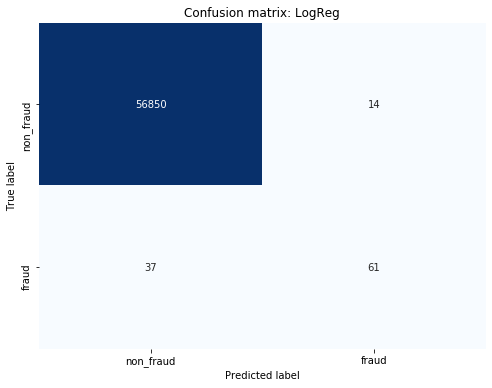

In [430]:
validate_model(LogisticRegression(), X_train, y_train, X_test,y_test, cv = cv)

Лог-регресия из под капота показывает вполне удовлетворяющие и стабильные результаты.Хороший показатель f1 на крос валидации и на вал-сэте. Модель очень хорошо различает фродовые от нефродовых транзакций, о чем говорит высокий Precision, также большинство фродовых транзакций от всех фродовых транзакций тоже были найдены - 61 по Recall для класса 1.

### lightgbm - baseline

Попробуем обучить ансамбль с бустом - lightgbm. Его я выбирал по причине достаточного быстрого обучения, чего не скажешь про xgboost или RF.

F1_score. Cross-validation: mean=0.077, std=0.056, test_set: 0.102
ROC_AUC_score. Cross-validation: mean=0.872, std=0.050, test_set: 0.881


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.05      0.79      0.10        98

    accuracy                           0.98     56962
   macro avg       0.53      0.88      0.55     56962
weighted avg       1.00      0.98      0.99     56962



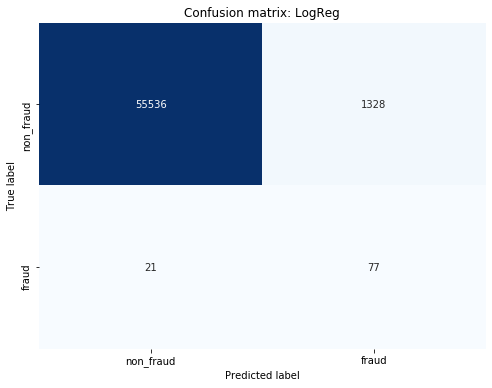

In [436]:
validate_model(lgb.LGBMClassifier(is_unbalance=True, silent=True), X_train, y_train, X_test,y_test, cv = cv)

С дефолтными гиперпараметрами лгбм - имеет довольно высокий Recall, высокий roc_auc на кроссвалидации и на тест-сэте. Но довольно низкий f1. На текущий момент фаворитом остается LR из-за своей стабильности, высокго f1 и roc_auc.

Попробуем применить методы для балансировки несбалансированных выборок, а именно SMOTE. По своему опыту скажу - ни в одной из всех задач это не помогло, но возможно нам повезет.

### Dealing with imbalance data

In [449]:
smt = SMOTE(random_state=SEED, sampling_strategy=0.3)
X_resampled, y_resampled = smt.fit_sample(X_train,y_train)

### LogisticRegression + SMOTE

F1_score. Cross-validation: mean=0.943, std=0.001, test_set: 0.274
ROC_AUC_score. Cross-validation: mean=0.993, std=0.000, test_set: 0.895


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.17      0.80      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.89      0.64     56962
weighted avg       1.00      0.99      1.00     56962



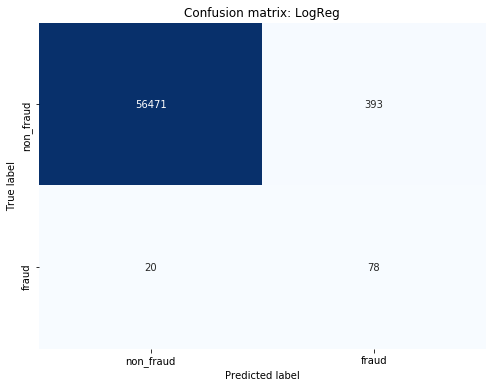

In [454]:
validate_model(LogisticRegression(), X_resampled, y_resampled, X_test,y_test, cv = cv)

Как сразу видно с отчета по обучение - мгновенный рост roc auc но очень сильно падение f1 :(

Попробуем на lightgbm.

### LightGBM + SMOTE

F1_score. Cross-validation: mean=0.998, std=0.000, test_set: 0.661
ROC_AUC_score. Cross-validation: mean=1.000, std=0.000, test_set: 0.877


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.59      0.76      0.66        98

    accuracy                           1.00     56962
   macro avg       0.79      0.88      0.83     56962
weighted avg       1.00      1.00      1.00     56962



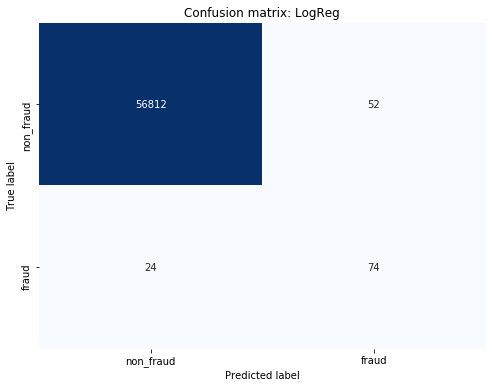

In [455]:
validate_model(lgb.LGBMClassifier(is_unbalance=True, silent=True), X_resampled, y_resampled, X_test,y_test, cv = cv)

После применения lightgbm SMOTE - заметен очень сильный рост и стабильность на фолдах по метрике f1 и очень высокий Roc_auc скоре на кроссвалидации и вал-сэте. Выберим lightGBM как главного победителя и подберем параметры.

### Hyperparameters tunning

In [460]:
param_dist = {
    "max_depth": [10, 15, 25, 50],
    "learning_rate": [0.003, 0.01, 0.03, 0.1],
    "num_leaves": [50, 100, 300, 500],
    "n_estimators": [50, 100, 200,300],
    'feature_fraction': [0.5, 0.8, 1],
    'bagging_fraction': [0.8, 0.9, 1]
}
lg_search = RandomizedSearchCV(lgb.LGBMClassifier(),
                           n_jobs=-1,
                           n_iter=20,
                           param_distributions=param_dist,
                           cv=cv,
                           scoring="f1",
                           verbose=5)

lg_search.fit(X_resampled, y_resampled)
lg_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.3min finished


LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.1, max_depth=25,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

F1_score. Cross-validation: mean=1.000, std=0.000, test_set: 0.816
ROC_AUC_score. Cross-validation: mean=1.000, std=0.000, test_set: 0.872


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.74      0.82        98

    accuracy                           1.00     56962
   macro avg       0.95      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



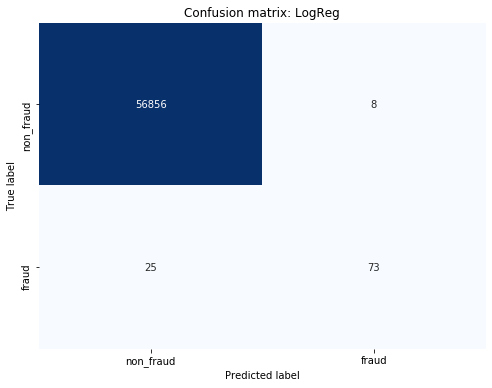

In [462]:
validate_model(lg_search.best_estimator_, X_resampled, y_resampled, X_test,y_test, cv = cv)

После поиска наилучших параметров light gbm показывает огромный прирост в roc_auc и f1, как на кроссвалидации так и на тесте.
Проверим наш класификатор на всех данных.

# Final evaluation

In [463]:
light_gbm_final = lg_search.best_estimator_

In [470]:
y_pred = light_gbm_final.predict_proba(X_test)

Roc_AUC: 0.872
F1: 0.816
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.74      0.82        98

    accuracy                           1.00     56962
   macro avg       0.95      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



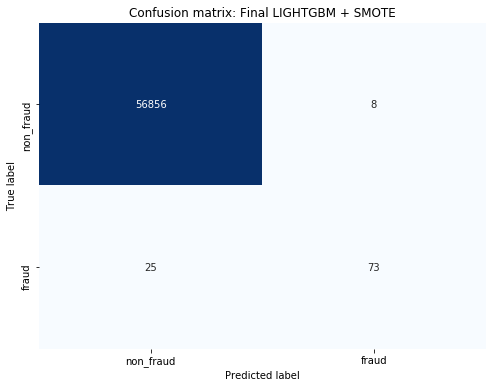

In [472]:
print(f"Roc_AUC: {roc_auc_score(y_test,y_pred[:,1] > 0.5):.3f}")
print(f"F1: {f1_score(y_test,y_pred[:,1] > 0.5):.3f}")
print(classification_report(y_test, y_pred[:,1]>0.5))
print_confusion_matrix(confusion_matrix(y_test,y_pred[:,1]>0.5),class_names=['non_fraud','fraud'],model_title='Final LIGHTGBM + SMOTE')

После подбора оптимальных параметров и применения класификатора на тест-выборке - 87 ROC AUC, 81 F1SCORE, удовлетворяющий precision и recall для обеих класов.